# Business problem description:

## The Better Scooter Company is an electric scooter rental sharing company. The company is seeking ways how they can improve their profitability. One effective way of doing so is via reducing repair costs associated with scooters.

## To solve this business problem, survival and exploratory analysis will be carried out to gain useful insights that the Better Scooter Company can benefit from. 

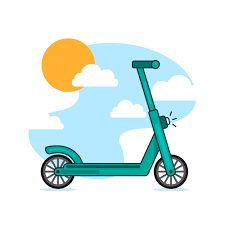

##  Description of the columns in our data:

1) **id(int)**: Identification number of scooter

2) **tte(float)**: Time to event(in hours) that scooter needed repair in if it broke down or if it didn't the time when the data was extracted

3) **need_repair(binary)**: Event, True= the scooter was repaired

4) **usage_length_days(float)**: Number of days that a scooter has been in use

5) **manufactor(categorical)**: Manufacturer of the scooter (A, B or C)

6) **avg_complains(float)**: Average number of complains in last three months

7) **riding miles(float)**: Accumulated riding miles of a scooter

## 1. Import necessary packages & load data 

In [129]:
#import necessary packages
import sksurv
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
from sksurv.datasets import get_x_y
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

In [130]:
#load data and see 1st 5 rows of the dataframe
df = pd.read_csv('cleaned_better_scooter.csv')
df.head()

,id,tte,need_repair,usage_length_days,manufactor,avg_complains,ride_miles
0,1,57.0,True,58.766838,C,21.3,6.2
1,2,736.0,False,56.447815,C,4.6,88.0
2,3,145.0,True,70.074472,B,1.8,88.4
3,4,275.0,True,54.742087,C,5.3,131.8
4,6,357.0,True,66.260541,A,0.7,60.0


## 2. Exploratory analysis & data cleaning

In [131]:
#explore the shape of the dataframe
df.shape

(283, 7)

In [132]:
#explore data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 283 non-null    int64  
 1   tte                283 non-null    float64
 2   need_repair        283 non-null    bool   
 3   usage_length_days  283 non-null    float64
 4   manufactor         283 non-null    object 
 5   avg_complains      283 non-null    float64
 6   ride_miles         283 non-null    float64
dtypes: bool(1), float64(4), int64(1), object(1)
memory usage: 13.7+ KB


In [133]:
#check for duplicate values
df['id'].nunique()

283

In [134]:
#summarize basic statistics for all the numerical variables
df.describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
id,283.0,150.0,89.0,1.0,72.0,148.0,222.0,312.0
tte,283.0,343.0,190.0,6.0,198.0,342.0,473.0,744.0
usage_length_days,283.0,51.0,10.0,29.0,44.0,51.0,58.0,78.0
avg_complains,283.0,7.0,8.0,0.0,1.0,2.0,11.0,41.0
ride_miles,283.0,127.0,93.0,6.0,71.0,113.0,160.0,1205.0


<span style="color:red">There are not any missing values and duplicate values. Therefore, no further actions are needed for data cleaning  </span>

## 3. Plot visualisations

Text(0.5, 1.0, 'Correlation between variables')

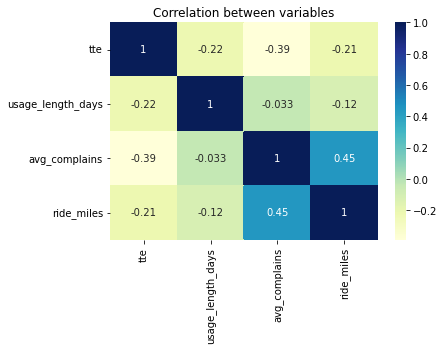

In [135]:
#explore correlation between numerical variables using heatmap
#id column has been excluded since it is just an observation
variables_heatmap = df[['tte', 'usage_length_days', 'avg_complains', 'ride_miles']]
sn.heatmap(variables_heatmap.corr(),annot=True, cmap = "YlGnBu").set_title('Correlation between variables')

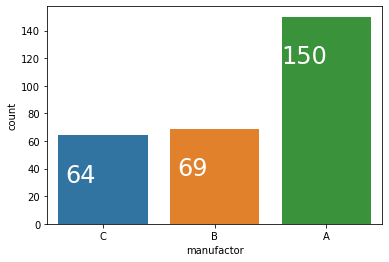

In [136]:
#explore the number of scooters and group them by manufacturer
scooter_counts = sn.countplot(x=df['manufactor'], data=df);
for scooter in scooter_counts.patches:
    scooter_counts.annotate(f'\n{scooter.get_height()}', (scooter.get_x()+0.2, scooter.get_height()), ha='center', va='top', color='white', size=24)

<AxesSubplot:title={'center':'Scooters need to be repaired by manufacturer'}, xlabel='Needed repair', ylabel='Count'>

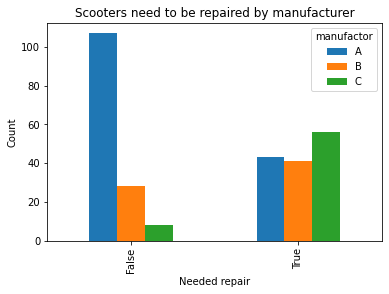

In [137]:
#explore the need to repair a scooter and group them manufacturer
need_to_repair = df.groupby(['need_repair', 'manufactor'])['manufactor'].count().unstack().plot.bar()
need_to_repair.set_xlabel("Needed repair")
need_to_repair.set_ylabel("Count")
need_to_repair.set_title("Scooters need to be repaired by manufacturer")
need_to_repair

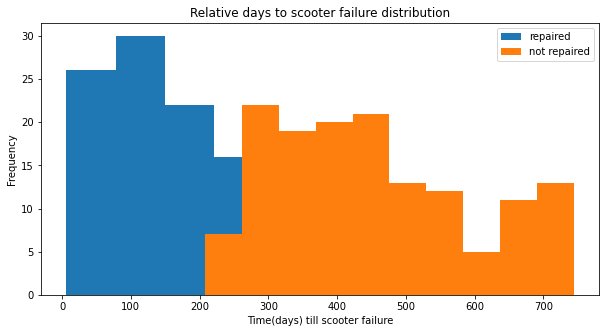

In [138]:
#explore the relationship between time to event(scooter failure) and potential need for repair distribution
ax = df['tte'].loc[df['need_repair'] == True].plot.hist(bins=10, label='repaired', figsize = (10,5))
ax = df['tte'].loc[df['need_repair'] == False].plot.hist(bins=10, label='not repaired')
ax.set_xlabel('Time(days) till scooter failure')
ax.set_title('Relative days to scooter failure distribution')
ax.legend();

### 3.1 Insights from the visualisations

#### -Of the 283 scooters owned by the Better Scooter Company majority(150) of them are manufactured by company A
#### -Scooters by company A also appear to be the most durable, where as the ones by company C are the least durable
#### -The scooters that have not been repaired before start to break down after roughly 200 days, whereas the ones that have been fixed before might begin to do so within a few days

## 4. Survival analysis

Text(0.5, 0, 'time $t(hours)$')

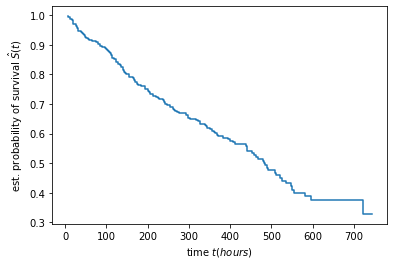

In [139]:
#creating the survival function with Kaplan-Meier(KM) estimator for the scooters
#plot KM curve
time, survival_prob = kaplan_meier_estimator(df["need_repair"], df["tte"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t(hours)$")

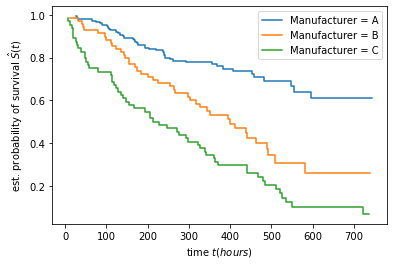

In [140]:
##creating the survival function with Kaplan-Meier(KM) estimator for each scooter maker
#plot KM curve for each scooter maker
for maker in ("A", "B", "C"):
    makerer = df["manufactor"] == maker
    time_failure, survival_prob = kaplan_meier_estimator(
        df["need_repair"][makerer],
        df["tte"][makerer])

    plt.step(time_failure, survival_prob, where="post",
             label="Manufacturer = %s" % maker)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t(hours)$")
plt.legend(loc="best")

### 4.1 Insights from the KM estimators

#### -Scooters by manufacturer A appear to have clearly the best odds of survival(not breaking down). From instance, 
#### -On the other hand, scooters by manufacturer C appear to have clearly the highest odds of breaking down

## 5. Log-rank test - continuation for part 4 

In [141]:
#make structured array for the log-rank test
#divide the data into features and labels
surv_features, surv_labels_df = get_x_y(df, ['need_repair','tte'],survival = False)
surv_labels = Surv.from_dataframe('need_repair','tte',surv_labels_df)
print('\n======== features for survival analysis ========\n', surv_features[:10])
print('\n======== labels for survival analysis ========\n',surv_labels[:10])


======== features for survival analysis ========
    id  usage_length_days manufactor  avg_complains  ride_miles
0   1          58.766838          C           21.3         6.2
1   2          56.447815          C            4.6        88.0
2   3          70.074472          B            1.8        88.4
3   4          54.742087          C            5.3       131.8
4   6          66.260541          A            0.7        60.0
5   7          55.536086          A            1.4        54.0
6   8          53.058263          B            5.4       120.9
7   9          42.509035          C           14.8       221.7
8  10          70.561822          C           12.6       147.3
9  11          53.715365          C            9.6       121.0

======== labels for survival analysis ========
 [( True,  57.) (False, 736.) ( True, 145.) ( True, 275.) ( True, 357.)
 (False, 357.) ( True, 352.) ( True, 342.) ( True,   8.) ( True, 536.)]


In [142]:
#perform  the log-rank test  
group_indicator = df['manufactor']
chisq, pvalue, stats, covar = compare_survival(surv_labels, group_indicator, return_stats=True)
chisq, pvalue, stats, covar

(61.06160595176763,
 5.503522413332893e-14,
        counts  observed   expected  statistic
 group                                        
 A         150        43  82.781297 -39.781297
 B          69        41  32.419593   8.580407
 C          64        56  24.799110  31.200890,
 array([[ 33.61122521, -19.07233748, -14.53888773],
        [-19.07233748,  24.83097546,  -5.75863798],
        [-14.53888773,  -5.75863798,  20.29752571]]))

### 5.1 Insights from the log-rank test

#### -P-value is 5.503522413332893e-14, which further validates that the manufacturer of a scooter has an influence on whether the tte variable would materialize
#### -This finding is also in alignment with the findings made by the km estimators

## 6. CoxnetSurvivalAnalysis

In [143]:
#make copy of the scooter data
#drop unwanted column(s)
#create dummy variables  
features_to_drop = ['id']
df2 = df.drop(features_to_drop, axis=1).copy()
dummies = pd.get_dummies(df2.manufactor)
df2 = pd.concat([df2, dummies], axis=1)
df2 = df2.drop(['manufactor'], axis=1)
df2.rename(columns = {'A':'manufactor_A', 'B':'manufactor_B',
                              'C':'manufactor_C'}, inplace = True)
df2.head()

,tte,need_repair,usage_length_days,avg_complains,ride_miles,manufactor_A,manufactor_B,manufactor_C
0,57.0,True,58.766838,21.3,6.2,0,0,1
1,736.0,False,56.447815,4.6,88.0,0,0,1
2,145.0,True,70.074472,1.8,88.4,0,1,0
3,275.0,True,54.742087,5.3,131.8,0,0,1
4,357.0,True,66.260541,0.7,60.0,1,0,0


In [144]:
#split data into target and feature matrices
surv_features, surv_labels_df = get_x_y(df2, ['need_repair','tte'],survival = False)
surv_labels = Surv.from_dataframe('need_repair','tte',surv_labels_df)

In [146]:
#deploy model and fit it
estimator = CoxPHSurvivalAnalysis()
estimator.fit(surv_features, surv_labels)

/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=1.40344e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=4.13914e-22): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=3.27159e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=2.56027e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: Li

CoxPHSurvivalAnalysis()

In [147]:
# c-index score (used to measure the accuracy of the model)
c_index_score = estimator.score(surv_features, surv_labels)
c_index_score

0.7758132154595943

In [148]:
#compute the most predictive features
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(surv_features.values, surv_labels)
pd.Series(scores, index=surv_features.columns).sort_values(ascending=False)

avg_complains        0.765329
ride_miles           0.684612
manufactor_A         0.636008
manufactor_C         0.612981
usage_length_days    0.608108
manufactor_B         0.523027
dtype: float64

### 6.1 Insights from the CoxnetSurvivalAnalysis

#### -Our model performs quite well, but is not perfect
#### -The two most predictive variables were ride_miles and avg_complains

## 7. Building a predictive model using synthetic data

In [152]:
#load the synthetic data
#see all the rows in the data (has only 10 different scooters)
synthetic_data = pd.read_csv('ten_scooters.csv')
synthetic_data

,id,usage_length_days,avg_complains,ride_miles,manufactor_A,manufactor_B,manufactor_C
0,1,56.447815,4.6,88.0,0,0,1
1,2,55.536086,1.4,54.0,1,0,0
2,3,53.058263,5.4,120.9,0,1,0
3,4,45.690505,1.2,72.0,1,0,0
4,5,64.647903,11.4,114.0,0,0,1
5,6,64.190669,7.8,73.0,0,0,1
6,7,52.026065,16.2,241.0,0,0,1
7,8,60.538276,11.4,246.0,0,1,0
8,9,45.211368,0.9,89.0,1,0,0
9,10,60.661483,2.1,98.0,0,0,1


In [158]:
#manipulate the dataframe to dictionary
x_new = synthetic_data.set_index(synthetic_data["id"]).drop(columns=["id"]).to_dict("index")

In [151]:
#convert the dataframe back into normal dataframe
x_new = pd.DataFrame.from_dict(x_new)
x_new

,1,2,3,4,5,6,7,8,9,10
usage_length_days,56.447815,55.536086,53.058263,45.690505,64.647903,64.190669,52.026065,60.538276,45.211368,60.661483
avg_complains,4.600000,1.400000,5.400000,1.200000,11.400000,7.800000,16.200000,11.400000,0.900000,2.100000
ride_miles,88.000000,54.000000,120.900000,72.000000,114.000000,73.000000,241.000000,246.000000,89.000000,98.000000
manufactor_A,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
manufactor_B,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
manufactor_C,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000


In [156]:
#deploy the predictive model and fit it
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=1.40344e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=4.13914e-22): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=3.27159e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=2.56027e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:445: Li

CoxPHSurvivalAnalysis()

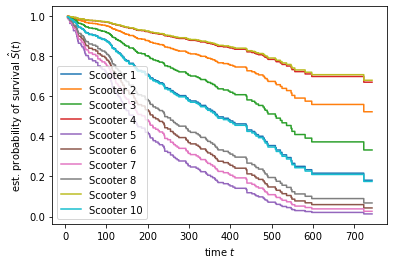

In [157]:
#plot estimated survival functions for the ten scooters
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(6, 744)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Scooter %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

### 7.1 Insights provided by the model

#### -Scooters 2, 4, and 9 appear to have the best odds of survival compared to other scooters
#### -These three scooters are all produced by company A, have the least avg_complains, and riding miles compared to the rest of the scooters

## 8. Recommendations for the Better Scooter Company based on our analyses

### -Prefer/favor scooters made by company A, as our analyses showcased that they are the most durable ones
### -Speak and gather feedback from customers once scooters starts to accumulate noticeable number of complaints, as it has an influence on when a scooter might start to break down and needs a fix
### -Service/maintain scooters more often once they start to accumulate noticeable number of riding miles, since riding miles has an influence on when a scooter might break down and needs a fix  